# INTRODUCTION TO NUMERICAL ICE-SHEET MODELLING

This notebook aims to provide an overview of basic numerical ice-sheet modelling concepts, including some example applications. The code is written in Python and requires [numpy](https://numpy.org), [matplotlib](https://matplotlib.org), and [ipywidgets](https://ipywidgets.readthedocs.io/) to be installed.

**TL;DR**

- examples for simple diffusion and advection models (FTCS) as well as a simple ice-sheet model based on the Shallow Ice Approximation (SIA) [1]
- 2d ("flowline"): $x$ denotes horizontal extend of the ice sheet, $z$ vertical ice thickness

**Author**

&copy; 2018, 2019, 2023 Julius Garbe ([✉️](mailto:julius.garbe@pik-potsdam.de)), Potsdam Institute for Climate Impact Research

***
<a id='toc'></a>
<h2>Contents</h2>

1. [Notebook setup](#setup)
2. [Forward in Time, Central in Space (FTCS) schemes](#ftcs)
<br>&nbsp;&nbsp;2.1 [Example 1: Diffusion](#ftcs_diffusion)
<br>&nbsp;&nbsp;2.2 [Example 2: Advection](#ftcs_advection)
<br>&nbsp;&nbsp;2.3 [Simulation](#ftcs_simulation)
3. [2D ice-sheet equation](#icesheet)
<br>&nbsp;&nbsp;3.1 [Analytical solution](#icesheet_analytical)
<br>&nbsp;&nbsp;3.2 [Example 1: Explicit solution](#icesheet_explicit)
<br>&nbsp;&nbsp;3.3 [Example 2: Semi-implicit solution](#icesheet_semiimplicit)
<br>&nbsp;&nbsp;3.4 [Simulation 1: Flat bed](#icesheet_flatbed)
<br>&nbsp;&nbsp;3.5 [Simulation 2: Sloped bed](#icesheet_slopedbed)
4. [Excursus: "Human finite differences"](#excursus)
5. [References](#refs)
***

<a id='setup'></a>
<h2>1. Notebook setup</h2>

In [1]:
# load Python libraries and set up notebook

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from ipywidgets import interact
import time

plt.rcParams['figure.figsize']=10,4
plt.rcParams['lines.linewidth']=3
plt.rcParams['font.size']=12
plt.rcParams['axes.titleweight']='bold'
plt.close('all')

In [2]:
# define a variable selector

def selector(my_choice):
    global choice
    choice = my_choice
    print('Your choice:',choice)

<a id='ftcs'></a>
<h2>2. Forward in Time, Central in Space (FTCS) schemes</h2>

- based on finite differences (i.e. divide model domain in regularly-spaced nodes on which variables are calculated)
- gradients/derivatives approximated by Taylor series expansion (omitt higher order derivatives)
$$H(t+\Delta t)\approx H(t)+\Delta t\frac{\partial H}{\partial t}+\frac{(\Delta t)^2}{2}\frac{\partial^2 H}{\partial t^2}+\dots$$

**Discretized Taylor approximations**
- *temporal* derivatives forward in time:
$$\frac{\partial H}{\partial t}\approx\frac{H_{t+\Delta t} - H_t}{\Delta t}$$

- *spatial* derivatives centered in space:
$$\frac{\partial H}{\partial x}\approx\frac{H_{i+1} - H_{i-1}}{2\Delta x}$$
$$\frac{\partial^2 H}{\partial x^2}\approx\frac{H_{i+1} - 2H_i + H_{i-1}}{(\Delta x)^2}$$

<div class="alert alert-block alert-warning"> The second derivative is determined by calculating local spatial gradients between consecutive grid points and taking gradient across these points, i.e., it is a symmetric derivative around $i$, involving only immediate neighbouring grid points $i+1$ and $i-1$</div>

<a id='ftcs_diffusion'></a>
<h3>2.1 Example 1: Diffusion</h3>

- slow point-to-point transfer of material (steady creep)

$$\frac{\partial H}{\partial t}=D \frac{\partial^2 H}{\partial x^2}$$
$D$: diffusion coefficient (in the code we replace $D$ with $D\Delta t$)

**FTCS scheme:**
$$H_{i,t+1} = H_{i,t} + \frac{D\Delta t}{(\Delta x)^2} (H_{i+1,t} - 2H_{i,t} + H_{i-1,t})$$

In [3]:
def diffusion(H,dx,m,D):
    
    Hn=np.array(H, copy=True) # copy existing H into new vector Hn
    
    for i in np.arange(1,m-1,1):
        Hn[i]=H[i]+D*(H[i+1]-2*H[i]+H[i-1])/dx**2
    H=np.array(Hn, copy=True) # copy new Hn back into old vector H
    
    return H

<a id='ftcs_advection'></a>
<h3>2.2 Example 2: Advection</h3>

- rapid transport of material with the motion of a fluid
- magnitude of transport velocity determined by surface gradient of hillslope

$$\frac{\partial H}{\partial t}=u \frac{\partial H}{\partial x}$$
$u$: displacement speed

**FTCS scheme:**
$$H_{i,t+1} = H_{i,t} + \frac{u\Delta t}{(2\Delta x)} (H_{i+1,t} - H_{i-1,t})$$

<div class="alert alert-block alert-warning"> Note that advection processes are inherently unstable. Solution: add a small amount of artificial diffusion in the code in order to stabilize the numerical integration ($D\ll u$).</div>

In [4]:
def advection(x,H,dx,m,D,u):
    
    Hn=np.array(H, copy=True) # copy existing H into new vector Hn

    for i in np.arange(1,m-1,1):
        if x[i]>=0:
            Hn[i]=H[i]+u*(H[i+1]-H[i-1])/(2*dx) + D*(H[i+1]-2*H[i]+H[i-1])/dx**2
        else:
            Hn[i]=H[i]-u*(H[i+1]-H[i-1])/(2*dx) + D*(H[i+1]-2*H[i]+H[i-1])/dx**2
    H=np.array(Hn, copy=True) # copy new Hn back into old vector H
    
    return H

**Initial conditions**

Slope at $t=0$:
$$H_{i,t=0} = 1 - \left|x_i\right|$$

**Boundary conditions**

*Dirichlet* boundary conditions (i.e. edge grid points remain constant over time):
$$H_1=H_m=0$$

<a id='ftcs_simulation'></a>
<h3>2.3 Simulation</h3>

In [5]:
# select method
interact(selector, my_choice=['advection','diffusion']);

interactive(children=(Dropdown(description='my_choice', options=('advection', 'diffusion'), value='advection')…

<IPython.core.display.Javascript object>


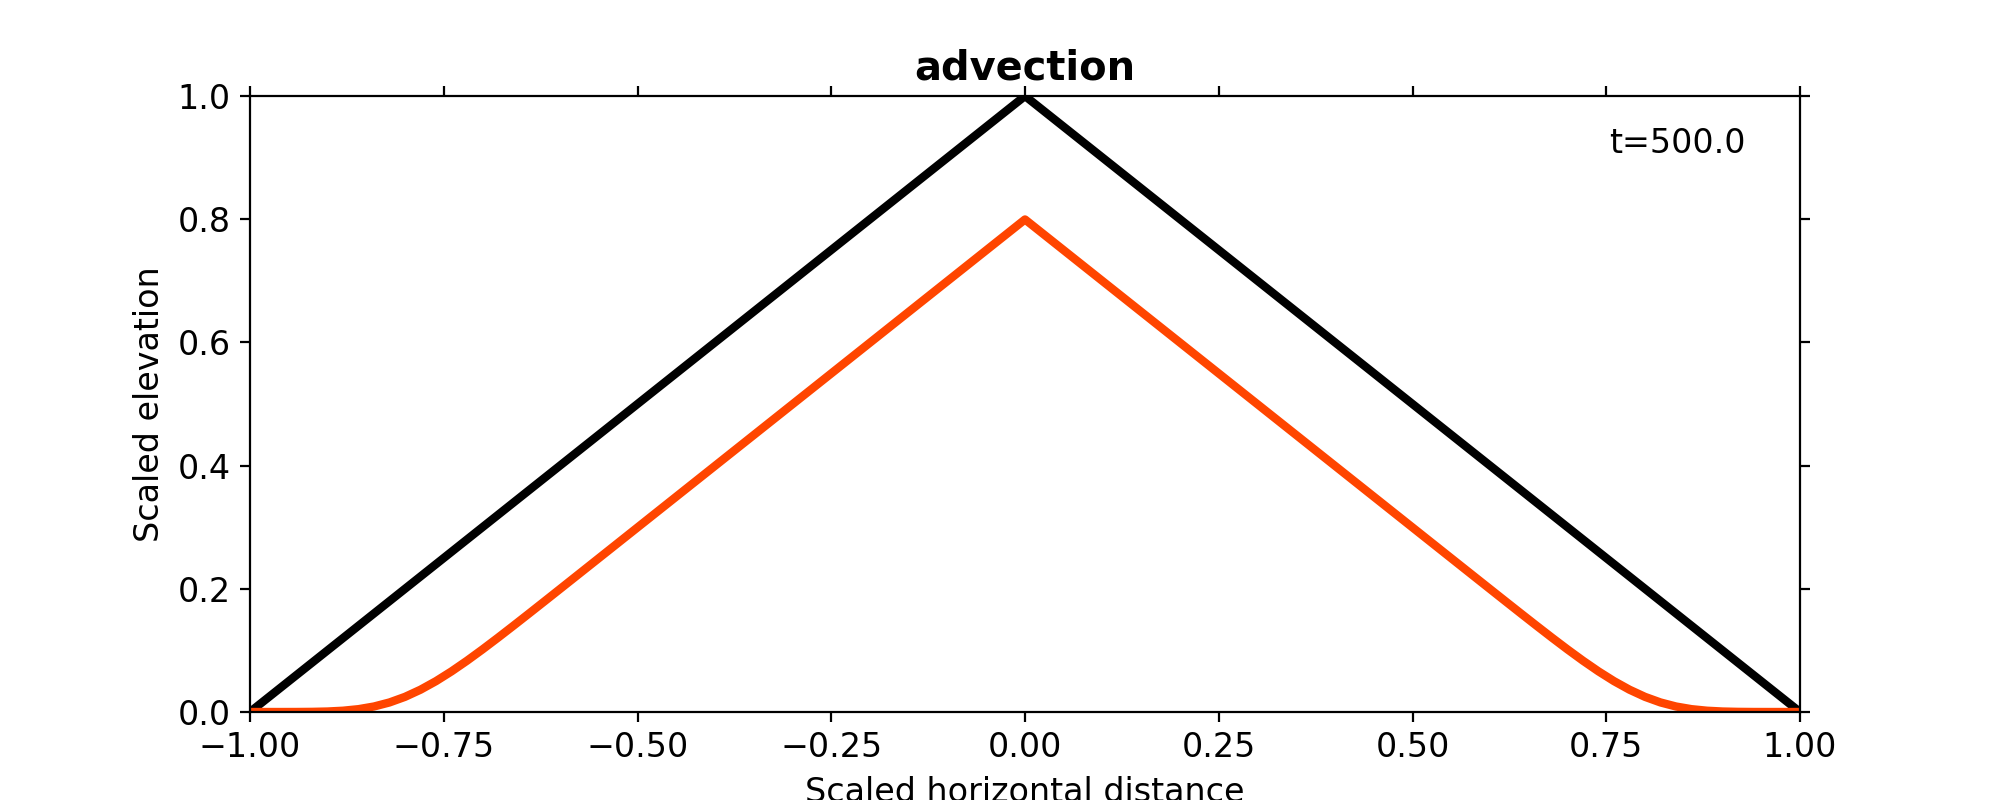

CPU times: user 51 s, sys: 1.97 s, total: 52.9 s
Wall time: 57.8 s


In [6]:
%%time

fig,ax = plt.subplots(1,1)

plt.ion()
fig.show()
fig.canvas.draw()


m=101 # number of grid points
x=np.linspace(-1,1,m) # horizontal distance
dx=2/(m-1) # grid spacing
time_end=500. # duration (years)
H=1-np.abs(x) # initial slope
H0=np.array(H, copy=True)


# time stepping
for t in np.arange(0,time_end+1,1):
    
    ax.clear()
    
    # plot initial slope
    ax.plot(x,H0, c='black')
    
    ax.set_xlim([-1,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('Scaled horizontal distance')
    ax.set_ylabel('Scaled elevation')
    ax.set_title(choice)

    if choice=='diffusion':
        H=diffusion(H,dx,m,D=2e-4)
    elif choice=='advection':
        H=advection(x,H,dx,m,D=4e-6,u=4e-4) #D=1e-4,u=4e-3 #D=4e-6,u=4e-4
        # try D=0 :)
    
    # plot new thickness
    ax.plot(x,H, c='orangered')
    ax.text(0.93,0.95, 't='+str(t), va='top', ha='right')
    
    fig.canvas.draw()
    time.sleep(0.01)

plt.show(fig)

<a id='icesheet'></a>
<h2>3. 2D ice-sheet equation</h2>

Vertical mean horizontal velocity (neglecting basal sliding) in flowline according to SIA:
$$\bar{u}=-\frac{2A}{n+2}(\rho_i g)^n \left|\frac{\partial s}{\partial x}\right|^{n-1} \frac{\partial s}{\partial x} h^{n+1}$$

$s=b+h$: surface elevation<br>
$A$: ice flow parameter (softness)<br>
$n$: Glen exponent<br>
$\rho_i$: ice density<br>
$g$: gravitation constant<br>

Thickness evolution:
$$\frac{\partial h}{\partial t}=-\frac{\partial (\bar{u}h)}{\partial x}+\dot{a}=-\frac{\partial q}{\partial x}+\dot{a}$$

$\dot{a}$: accumulation rate<br>
$q$: flux

In [7]:
# Model setup
m=51 # number of grid points
L=1.5e6 # length of domain (m)
x=np.linspace(0,L,m) # horizontal distance
dx=L/(m-1) # grid spacing (m)
d=np.zeros(m) # diffusion coefficients
time_end=20000. # duration (years)

# Physical constants
A=1e-16 # Ice flow parameter
rho=910. # Ice density
grav=9.81 # Gravitation constant
n=3 # Glen index
a=0.3 # Surface mass balance

<a id='icesheet_analytical'></a>
<h3>3.1 Analytical solution</h3>

Assumptions:
- flat, rigid bed: $b=0$, i.e. $s=h$
- no basal sliding
- constant surface mass balance over whole  domain $\dot{a}$

*Vialov profile* [2] for steady state:
$$h(x)=h_0\left[1-\left(\frac{x}{L}\right)^{(n+1)/n}\right]^{n/(2n+2)}$$

with thickness at ice divide
$$h_0=2^{n/(2n+2)}\left(\frac{\dot{a}}{A_0}\right)^{1/(2n+2)} \sqrt{L}$$

and
$$A_0=\frac{2A}{n+2}(\rho_i g)^n$$

In [8]:
# Set to True to create a plot, False otherwise
create_plot = True

<IPython.core.display.Javascript object>


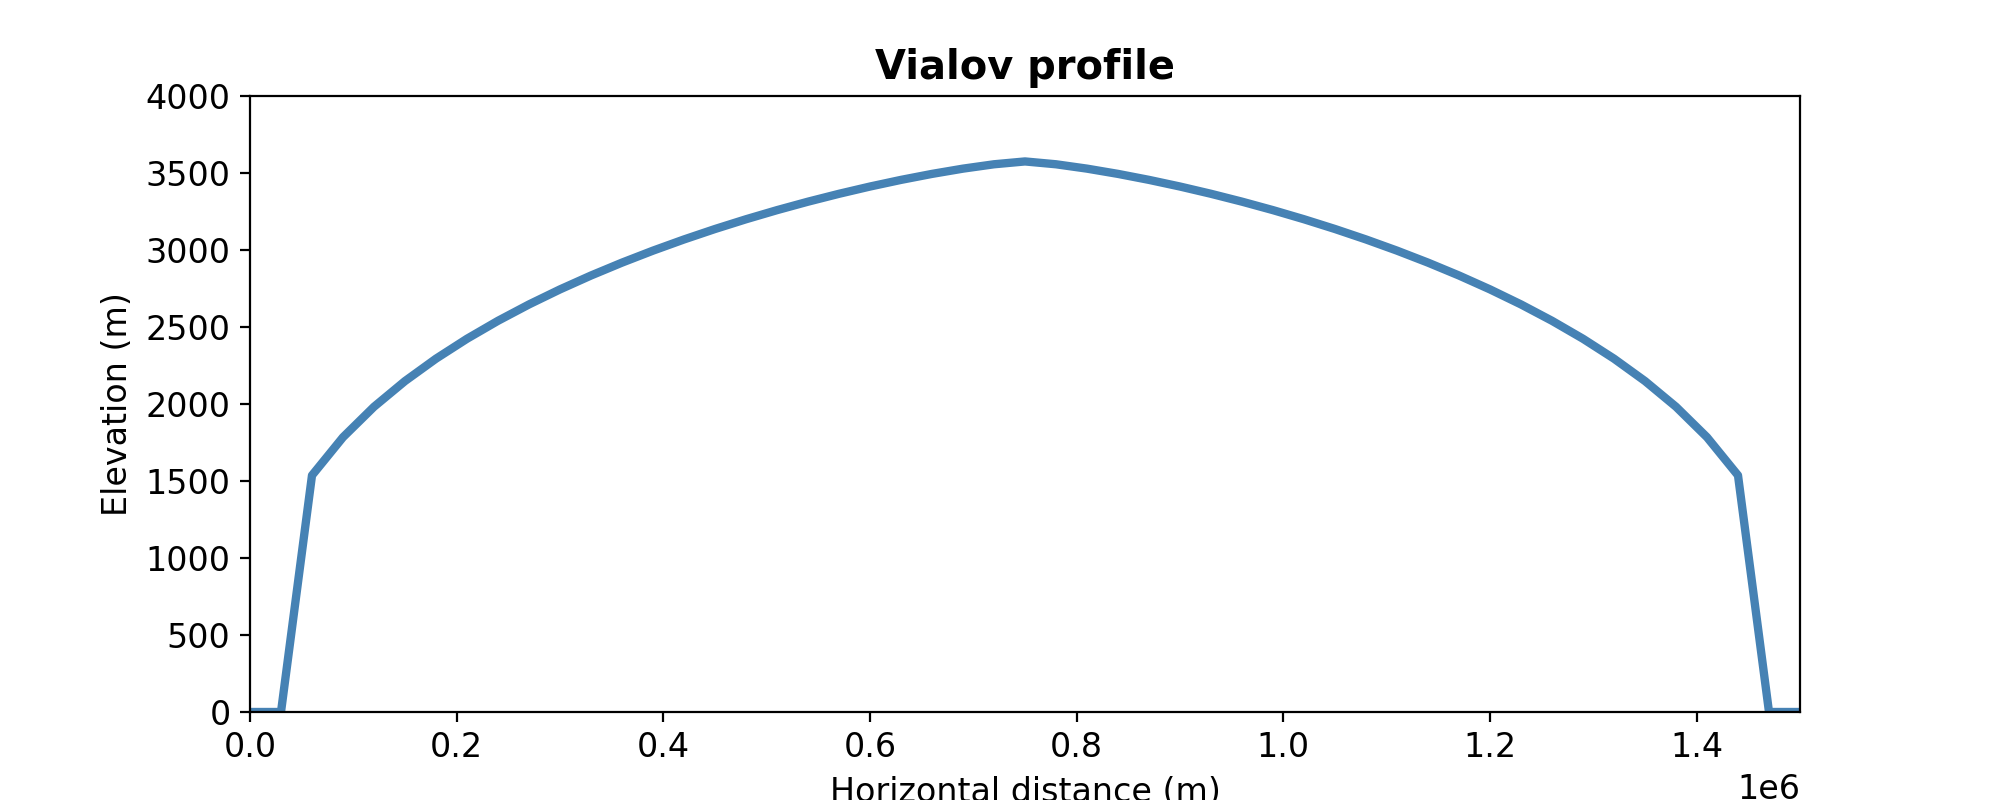

In [9]:
def vialov(L,m):
    
    Lv=L/2. # length of half-domain (m)
    xv=np.linspace(-Lv,Lv,m) # horizontal distance from ice divide (m)
    hv=np.zeros(m)
    
    A0=2./(n+2.)*A*(rho*grav)**n
    h0=2**(n/(2.*n+2.))*(a/A0)**(1./(2.*n+2))*Lv**0.5 # surface elevation at ice divide
    
    for j in np.arange(2,m-2,1):
        if xv[j]<=0:
            hv[j]=h0*(1-(np.abs(xv[j])/Lv)**((n+1.)/n))**(n/(2.*n+2))
        elif xv[j]>0:
            hv[j]=h0*(1-(xv[j]/Lv)**((n+1.)/n))**(n/(2.*n+2))
    
    return hv


# create plot
if create_plot:
    fig = plt.figure()
    
    hv=vialov(L,m)
    plt.plot(x,hv, c='steelblue')
        
    plt.xlim([0,L])
    plt.ylim([0,4000])
    plt.xlabel('Horizontal distance (m)')
    plt.ylabel('Elevation (m)')
    plt.title('Vialov profile')
    
    plt.show(fig)

<a id='icesheet_explicit'></a>
<h3>3.2 Example 1: Explicit solution</h3>

<div class="alert alert-block alert-warning">
<ul>
    <li>diffusion problem</li>
    <li>requires small time steps to remain stable</li>
    <li>$\sim$ 20 min. for 20,000 years with $\Delta t$=2 years (on 2.8 GHz Intel Core i7 processor)</li>
</ul>
</div>

**FTCS scheme:**
$$h_{i,t+1}=h_{i,t}+\left[q_{i+\frac{1}{2},t}-q_{i-\frac{1}{2},t}\right]\frac{\Delta t}{\Delta x}+\dot{a}\Delta t$$

with fluxes between grid points
$$q_{i+\frac{1}{2},t}=\frac{2A}{n+2}(\rho_i g)^n \left(\frac{h_{i+1,t}+b_{i+1,t}-h_{i,t}-b_{i,t}}{\Delta x}\right)^n \left(\frac{h_{i,t}+h_{i+1,t}}{2}\right)^{n+2}$$
$$q_{i-\frac{1}{2},t}=\frac{2A}{n+2}(\rho_i g)^n \left(\frac{h_{i,t}+b_{i,t}-h_{i-1,t}-b_{i-1,t}}{\Delta x}\right)^n \left(\frac{h_{i,t}+h_{i-1,t}}{2}\right)^{n+2}$$

Pure advection equations can be numerically unstable in FTCS. In reality, the continuity equation is a diffusive equation due to the dependence of $q$ on $\partial h/\partial x$:

$$\frac{\partial h}{\partial t}=-\frac{\partial (\bar{u}h)}{\partial x}+\dot{a}=\frac{\partial}{\partial x}\left(d\frac{\partial (h+b)}{\partial x}\right)+\dot{a}$$

with diffusion coefficient
$$d=-\bar{u}h\left(\frac{\partial (h+b)}{\partial x}\right)^{-1}=-\frac{2A}{n+2}(\rho_i g)^n \left|\frac{\partial (h+b)}{\partial x}\right|^{n-2} \frac{\partial (h+b)}{\partial x} h^{n+2}$$

Diffusion terms (i.e. transformed flux terms) are evaluated between grid points ("staggered grid"):
$$d_{i+\frac{1}{2},t}=\frac{2A}{n+2}(\rho_i g)^n \left|\frac{h_{i+1,t}+b_{i+1,t}-h_{i,t}-b_{i,t}}{\Delta x}\right|^{n-1} \left(\frac{h_{i,t}+h_{i+1,t}}{2}\right)^{n+2}$$
$$d_{i-\frac{1}{2},t}=\frac{2A}{n+2}(\rho_i g)^n \left|\frac{h_{i,t}+b_{i,t}-h_{i-1,t}-b_{i-1,t}}{\Delta x}\right|^{n-1} \left(\frac{h_{i,t}+h_{i-1,t}}{2}\right)^{n+2}$$

$$h_{i,t+1}=h_{i,t}+ \frac{\Delta t}{(\Delta x)^2} \left[d_{i+\frac{1}{2},t}(h_{i+1,t}+b_{i+1,t}-h_{i,t}-b_{i,t})-d_{i-\frac{1}{2},t}(h_{i,t}+b_{i,t}-h_{i-1,t}-b_{i-1,t})\right]+\dot{a}\Delta t$$

<img src="images/staggeredgrid.png" width="400" alt="Staggered grid used in the flowline model" />

<center><b>Figure:</b> Staggered grid used in the flowline model.</center>

In [10]:
def explicit(b,h,dx,dt):
        
    slope=np.diff(b+h)/dx # slope on staggered grid
    
    for j in np.arange(1,m-1,1):
        hstag=(h[j+1]+h[j])/2. # ice thickness on staggered grid
        d[j]=2./(n+2.)*A*hstag**2*slope[j]**2*(rho*grav*hstag)**n
    
    h2=np.zeros(m)
    for j in np.arange(2,m-2,1):
        h2[j]=h[j]+(d[j]*slope[j]-d[j-1]*slope[j-1])*dt/dx+a*dt
    h=np.array(h2, copy=True)
    
    return h

<a id='icesheet_semiimplicit'></a>
<h3>3.3 Example 2: Semi-implicit solution</h3>

<div class="alert alert-block alert-warning">
<ul>
    <li>greater numerical stability by evaluating right-hand side on timestep $t+1$ instead of $t$ ("implicit")</li>
    <li>$\sim$ 10 min. for 20,000 years with $\Delta t$=2 years (on 2.8 GHz Intel Core i7 processor)</li>
</ul>
</div>

**FTCS scheme:**
$$h_{i,t+1}=h_{i,t}+\frac{\Delta t}{(\Delta x)^2}\left[d_{i+\frac{1}{2},t}(h_{i+1,t+1}+b_{i+1,t}-h_{i,t+1}-b_{i,t})-d_{i-\frac{1}{2},t}(h_{i,t+1}+b_{i,t}-h_{i-1,t+1}-b_{i-1,t})\right]+\dot{a}\Delta t$$

Sort terms:
$$h_{i,t+1}-\frac{\Delta t}{(\Delta x)^2}\left[d_{i+\frac{1}{2},t}(h_{i+1,t+1}-h_{i,t+1})-d_{i-\frac{1}{2},t}(h_{i,t+1}-h_{i-1,t+1})\right]=h_{i,t}+\frac{\Delta t}{(\Delta x)^2}\left[d_{i+\frac{1}{2},t}(b_{i+1,t}-b_{i,t})-d_{i-\frac{1}{2},t}(b_{i,t}-b_{i-1,t})\right]+\dot{a}\Delta t$$

Define coefficients:
$$\alpha_i=\frac{\Delta t}{(\Delta x)^2}d_{i-\frac{1}{2},t}$$
$$\beta_i=1+\frac{\Delta t}{(\Delta x)^2}\left(d_{i-\frac{1}{2},t}+d_{i+\frac{1}{2},t}\right)$$
$$\gamma_i=\frac{\Delta t}{(\Delta x)^2}d_{i+\frac{1}{2},t}$$
$$\delta_i=\alpha_ib_{i-1,t}-(\beta_i-1)b_{i,t}+\gamma_ib_{i+1,t}+h_{i,t}+\dot{a}\Delta t$$

Such that:
$$-\alpha_ih_{i-1,t+1}+\beta_ih_{i,t+1}-\gamma_ih_{i+1,t+1}=\delta_i$$

This system of equations can be written in matrix notation giving a tridiagonal matrix (all non-zero elements occur on the diagonal axis as well as the two adjacent axes). Such a system can easily be solved with the method below. Consider the following two equations that hold between two adjacent grid points:

$$h_{i}=f_{i}h_{i+1}+g_{i}$$
$$h_{i-1}=f_{i-1}h_{i}+g_{i-1}$$

Multiply second equation by $\alpha_i$:
$$\alpha_ih_{i-1}=\alpha_if_{i-1}h_{i}+\alpha_ig_{i-1}=\beta_ih_{i}-\gamma_ih_{i+1}-\delta_i$$

Combine equations:
$$h_i=\frac{\gamma_i}{\beta_i-\alpha_if_{i-1}}h_{i-1}+\frac{\delta_i+\alpha_ig_{i-1}}{\beta_i-\alpha_if_{i-1}}$$

where
$$f_i=\frac{\gamma_i}{\beta_i-\alpha_if_{i-1}}, \qquad g_i=\frac{\delta_i+\alpha_ig_{i-1}}{\beta_i-\alpha_if_{i-1}}$$

In [11]:
def semi_implicit(b,h,dx,dt,dtdx,alpha,beta,gamma,delta,f,g):
    
    slope=np.diff(b+h)/dx # slope on staggered grid
    
    for j in np.arange(1,m-1,1):
        hstag=(h[j+1]+h[j])/2. # ice thickness on staggered grid
        d[j]=2./(n+2.)*A*hstag**2*slope[j]**2*(rho*grav*hstag)**n
    
    for j in np.arange(2,m-2,1):
        gamma[j]=d[j]*dtdx
        alpha[j]=d[j-1]*dtdx
        beta[j]=1.+gamma[j]+alpha[j]
        delta[j]=h[j]+a*dt+alpha[j]*b[j-1]-(beta[j]-1)*b[j]+gamma[j]*b[j+1]
    
    for j in np.arange(2,m-2,1):
        f[j]=gamma[j]/(beta[j]-alpha[j]*f[j-1])
        g[j]=(delta[j]+alpha[j]*g[j-1])/(beta[j]-alpha[j]*f[j-1])
    
    h2=np.zeros(m)
    for j in np.arange(m-2,0,-1):
        h2[j]=g[j]+f[j]*h2[j+1]
    h=np.array(h2, copy=True)
    
    return h

**Initial conditions**

No ice at $t=0$:
$$H_{i,t=0} = 0$$

**Boundary conditions**

*Dirichlet* boundary conditions (i.e. edge grid points remain constant over time):
$$H_1=H_m=0$$

Additionally, we have for the semi-implicit method:
$$f_1=f_m=g_1=g_m=0$$

In [12]:
# select method
interact(selector, my_choice=['semi-implicit','explicit']);

interactive(children=(Dropdown(description='my_choice', options=('semi-implicit', 'explicit'), value='semi-imp…

<a id='icesheet_flatbed'></a>
<h3>3.4 Simulation 1: Flat bed</h3>

<IPython.core.display.Javascript object>


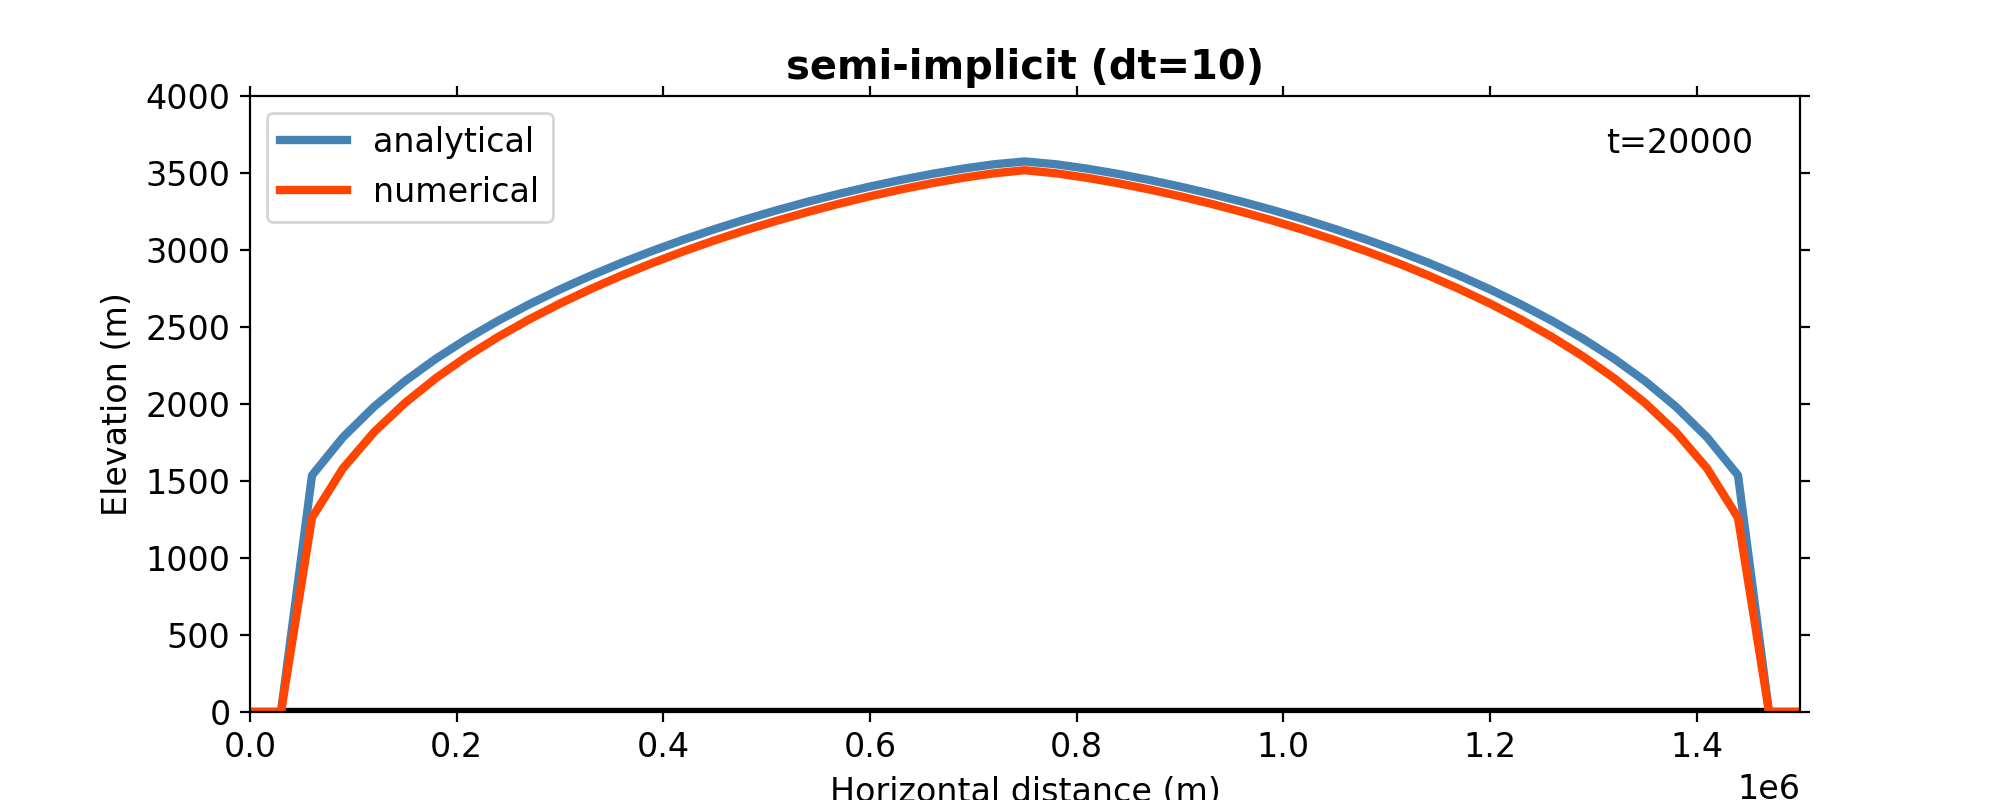

CPU times: user 3min 42s, sys: 9.27 s, total: 3min 51s
Wall time: 3min 51s


In [13]:
%%time

fig,ax = plt.subplots(1,1)

plt.ion()
fig.show()
fig.canvas.draw()


# Initialize model
h=np.zeros(m) # initial thickness
b=np.zeros(m) # bedrock elevation

if choice=='explicit':
    dt=2. # time step (years)
    
elif choice=='semi-implicit':
    dt=10. # time step (years)
    dtdx=dt/dx**2
    
    # initialize vectors
    alpha=np.zeros(m)
    beta=np.zeros(m)
    gamma=np.zeros(m)
    delta=np.zeros(m)
    f=np.zeros(m)
    g=np.zeros(m)


# time stepping
for t in np.arange(0,time_end+1,dt):
    
    ax.clear()
    
    if choice=='explicit':
        h=explicit(b,h,dx,dt)
    elif choice=='semi-implicit':
        h=semi_implicit(b,h,dx,dt,dtdx,alpha,beta,gamma,delta,f,g)
        
    # plot bedrock
    ax.plot(x,b, c='black')
    
    # plot Vialov profile
    hv=vialov(L,m)
    ax.plot(x,hv, c='steelblue', label='analytical')
    
    # plot thickness profile
    ax.plot(x,h, c='orangered', label='numerical')
    ax.text(0.97,0.95, 't='+str(int(t)), transform=ax.transAxes, va='top', ha='right')
    
    ax.set_xlim([0,L])
    ax.set_ylim([0,4000])
    ax.set_xlabel('Horizontal distance (m)')
    ax.set_ylabel('Elevation (m)')
    ax.set_title(choice+r' (dt='+str(int(dt))+')')
    ax.legend(loc="upper left")
    
    fig.canvas.draw()
    time.sleep(0.0001)


<a id='icesheet_slopedbed'></a>
<h3>3.5 Simulation 2: Sloped bed</h3>

In [14]:
# select bed shape
interact(selector, my_choice=['trough','bump','slope']);

interactive(children=(Dropdown(description='my_choice', options=('trough', 'bump', 'slope'), value='trough'), …

<IPython.core.display.Javascript object>


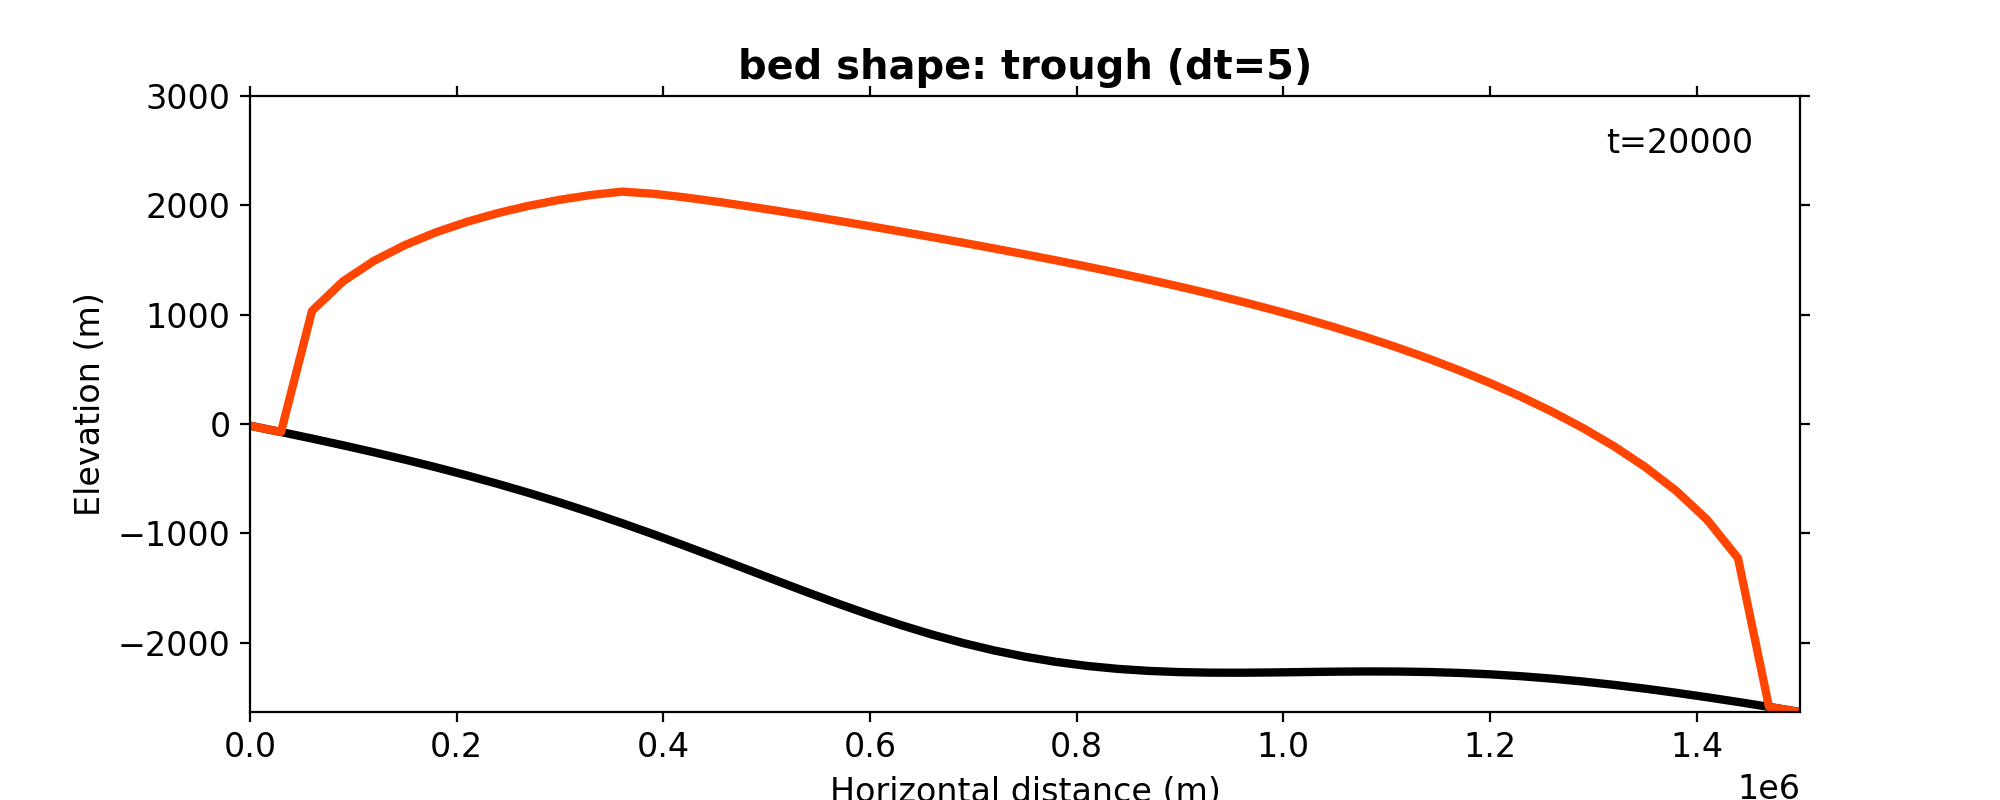

CPU times: user 6min 34s, sys: 15 s, total: 6min 49s
Wall time: 6min 49s


In [15]:
%%time

fig,ax = plt.subplots(1,1)

plt.ion()
fig.show()
fig.canvas.draw()


# Initialize model
h=np.zeros(m) # initial thickness

# bed shape
angle=0.1 # bedrock slope in degrees
tan=np.tan(angle*np.pi/180)
if choice=='slope':
    b=-tan*x
elif choice=='bump':
    b=-tan*x+np.exp(-(x-L/2.)**2/(L/4.)**2)/(0.7*tan)
elif choice=='trough':
    b=-tan*x-np.exp(-(x-L/2.)**2/(L/4.)**2)/(0.7*tan)
else:
    b=np.zeros(m)

dt=5. # time step (years)
dtdx=dt/dx**2

# initialize vectors
alpha=np.zeros(m)
beta=np.zeros(m)
gamma=np.zeros(m)
delta=np.zeros(m)
f=np.zeros(m)
g=np.zeros(m)


# time stepping
for t in np.arange(0,time_end+1,dt):
    
    ax.clear()
    
    h=semi_implicit(b,h,dx,dt,dtdx,alpha,beta,gamma,delta,f,g)
        
    # plot bedrock
    ax.plot(x,b, c='black')
        
    # plot thickness profile
    ax.plot(x,b+h, c='orangered')
    ax.text(0.97,0.95, 't='+str(int(t)), transform=ax.transAxes, va='top', ha='right')
    
    ax.set_xlim([0,L])
    ax.set_ylim([np.min(b+h),3000])
    ax.set_xlabel('Horizontal distance (m)')
    ax.set_ylabel('Elevation (m)')
    ax.set_title('bed shape: '+choice+r' (dt='+str(int(dt))+')')
    
    fig.canvas.draw()
    time.sleep(0.0001)


<a id='excursus'></a>
<h2>4. Excursus: "Human finite differences"</h2>

Temperature diffusion according to
$$\frac{\partial T}{\partial t}=k\frac{\partial^2 T}{\partial x^2}$$

$k$: diffusion coefficient

**FTCS scheme:**
$$T_{i,t+1} = T_{i,t} + k\frac{\Delta t}{(\Delta x)^2} (T_{i+1,t} - 2T_{i,t} + T_{i-1,t})$$

**Initial conditions**

$T_{2,t=0}\dots T_{m-1,t=0}=10^\circ C$

**Boundary conditions**

$T_{1}=T_{m}=20^\circ C$ for all $t$

<IPython.core.display.Javascript object>


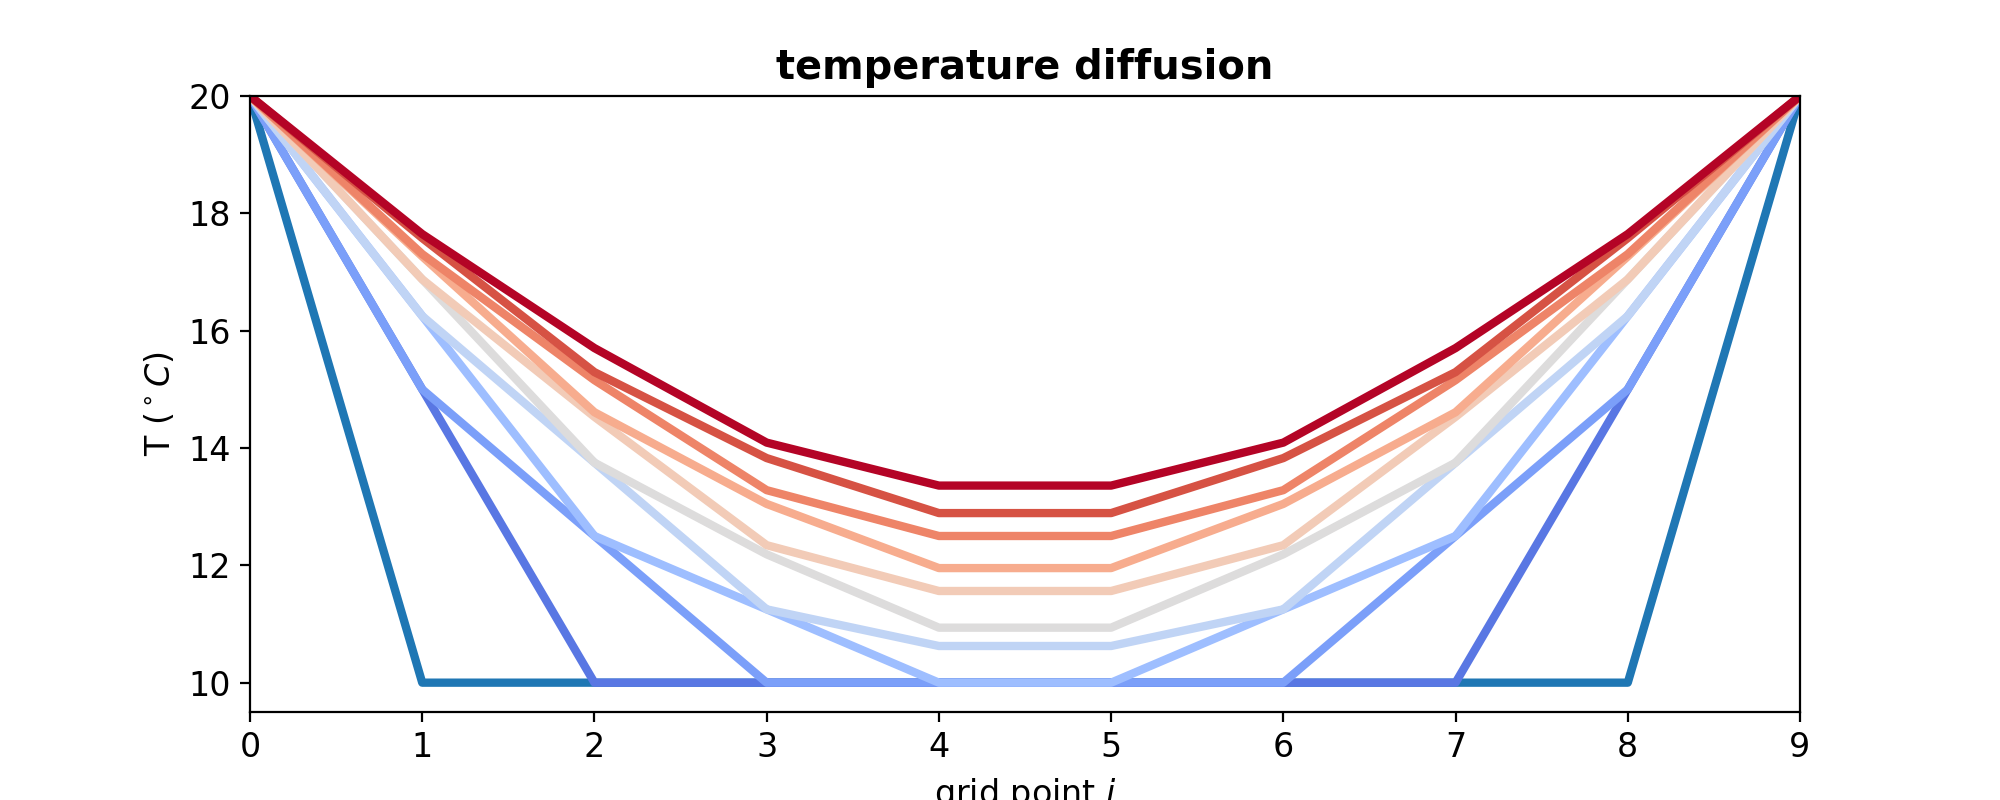

t=0: [20. 10. 10. 10. 10. 10. 10. 10. 10. 20.]
t=1: [20. 15. 10. 10. 10. 10. 10. 10. 15. 20.]
t=2: [20.  15.  12.5 10.  10.  10.  10.  12.5 15.  20. ]
t=3: [20.   16.25 12.5  11.25 10.   10.   11.25 12.5  16.25 20.  ]
t=4: [20.   16.25 13.75 11.25 10.62 10.62 11.25 13.75 16.25 20.  ]
t=5: [20.   16.88 13.75 12.19 10.94 10.94 12.19 13.75 16.88 20.  ]
t=6: [20.   16.88 14.53 12.34 11.56 11.56 12.34 14.53 16.88 20.  ]
t=7: [20.   17.27 14.61 13.05 11.95 11.95 13.05 14.61 17.27 20.  ]
t=8: [20.   17.3  15.16 13.28 12.5  12.5  13.28 15.16 17.3  20.  ]
t=9: [20.   17.58 15.29 13.83 12.89 12.89 13.83 15.29 17.58 20.  ]
t=10: [20.   17.65 15.7  14.09 13.36 13.36 14.09 15.7  17.65 20.  ]


In [16]:
m=10
k=0.5
Tmin=10.
Tmax=20.
T=np.ones(m)*Tmin
T[0]=T[m-1]=Tmax

fig = plt.figure()

plt.ion()
fig.show()
fig.canvas.draw()

print('t=0: '+str(np.round(T,2)))

plt.plot(T)

# time stepping
for t in np.arange(1,11,1):
            
    Tn=np.array(T, copy=True)
    
    for i in np.arange(1,m-1,1):
        Tn[i]=T[i]+k*(T[i+1]-2.*T[i]+T[i-1])
        
    T=np.array(Tn, copy=True)
    
    print('t='+str(t)+': '+str(np.round(T,2)))

    plt.plot(T, color=cm.coolwarm(np.float(t)/10.))
    
    plt.xlim([0,m-1])
    plt.ylim([Tmin-0.5,Tmax])
    plt.xlabel('grid point $i$')
    plt.ylabel('T ($^\circ C$)')
    plt.title('temperature diffusion')
    
    fig.canvas.draw()
    time.sleep(0.25)

plt.show()

<a id='refs'></a>
<h2>5. References</h2>

[1] Pattyn, F.: *Numerical modelling of ice sheets and ice shelves*, lecture notes from the Karthaus Summer School (2018)<br>
[2] Vialov, S. S.: *Regularities of glacier shields movement and the theory of plastic viscous flow*, *Int. Ass. Hydrol. Sci. Pub.* **47**, pp. 266-275 (1958)